# Figure 1a-b

This notebook loads the data and produces figure 1a, 1b, and S1. The intermediate file "figure1ab_figureS1.csv" is saved here and reloaded to be used for the figure. You can reproduce the figure starting from that point in the code by downloading the file from our data repository. You will need to separately download the shape files https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2024.html.

In [1]:
savedate = '20251031'

In [2]:
data_path = '' # path to data - not needed for you to rerun figure
geodata_path = '' # save the shape file folders here
figuredata_path = '' # save the data from the data repository here in a subfolder called "FigureData"

In [3]:
import pandas as pd
import geopandas as geopd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
import numpy as np
import state_name_crs_mappings_ML as crsm
pd.options.mode.chained_assignment = None
crs = int(crsm.state_to_crs(crsm.abbrev_to_state('MS')).split(':')[1])
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load maps and data

In [4]:
# County-level shape file
gdf_county = geopd.read_file(geodata_path + 'tl_2022_us_county/tl_2022_us_county.shp')
gdf_county = gdf_county.to_crs(epsg=crs)

# Data
df_bg_level = pd.read_csv(data_path + '23_level_BG_US_imputedquantiles_20250722.zip',dtype={'GEOID':str,'STATEFP':str,'COUNTYFP':str,'BGFIPS':str},index_col=0)
df_bg_level['STATEFP'] = df_bg_level['STATEFP'].str.zfill(2)
df_bg_level['COUNTYFP'] = df_bg_level['COUNTYFP'].str.zfill(5)

# Merge data file with map
tmp1 = df_bg_level.groupby(['COUNTYFP'])[['total_pop_byBG', 'no_stations']].sum()
tmp2 = df_bg_level.groupby(['COUNTYFP'])[['income_quantile_county_state_imputed', 'income_quantile_county_US_imputed']].mean()
tmp3 = tmp1.merge(tmp2, on='COUNTYFP')
gdf_county['COUNTYFP5'] = gdf_county['STATEFP'].astype(str) + gdf_county['COUNTYFP'].astype(str)
gdf_county = pd.merge(gdf_county, tmp3.reset_index(names=['COUNTYFP5']), on='COUNTYFP5')
gdf_county['stations_pp'] = gdf_county['no_stations'] / gdf_county['total_pop_byBG']

# Calculate quantiles at US level
# Note: for 'stations_pp', bottom two bins both have 0 as all or left edge. Need to merge. 
merged_edges = [gdf_county['stations_pp'].quantile(qu) for qu in [0, 0.4, 0.6, 0.8, 1.0]]
gdf_county['stations_pp_quantile'] = pd.cut(gdf_county['stations_pp'], bins=merged_edges, include_lowest=True, 
                                            labels=[1, 3, 4, 5])

# Calculate quantiles at state level
for state in gdf_county['STATEFP'].unique():
    state_inds = gdf_county[gdf_county['STATEFP']==state].index
    if state == '11':
#         print('Special case for DC with only one county')
        gdf_county.loc[state_inds, 'stations_pp_quantile_state'] = 3
    else:
        edges_all = [gdf_county.loc[state_inds, 'stations_pp'].quantile(qu) for qu in [0, 0.2, 0.4, 0.6, 0.8, 1.0]]
        first_nonzero_ind = np.where(np.array(edges_all) > 0)[0][0]
        if first_nonzero_ind <= 1: # enough counties in state with stations to have full set of bins
            labels=[1,2,3,4,5]
            merged_edges = edges_all
        else: # multiple bins with zero as the edge, so need to merge
            merged_edges = [edges_all[0]] + edges_all[first_nonzero_ind:]
            labels = [1] + list(np.arange(first_nonzero_ind+1, 6))

        gdf_county.loc[state_inds, 'stations_pp_quantile_state'] = pd.cut(gdf_county.loc[state_inds, 'stations_pp'], bins=merged_edges, include_lowest=True, labels=labels).values.astype(int)

## Save and reload 
Then the following plotting script can be run by anyone using the posted data.

In [5]:
# Save key data for "FigureData"
gdf_county.loc[:, ['STATEFP', 'COUNTYFP', 'GEOID', 'NAME', 'stations_pp_quantile', 'stations_pp_quantile_state',
                   'income_quantile_county_US_imputed', 'income_quantile_county_state_imputed', 
                   ]].to_csv(figuredata_path + 'FigureData/figure1ab_figureS1.csv')

### Run from here if reloading data

In [6]:
# Load back data
data = pd.read_csv(figuredata_path + 'FigureData/figure1ab_figureS1.csv', index_col=0, dtype={'STATEFP':str, 'COUNTYFP':str, 'GEOID':str})

# Load shapefile
gdf_county = geopd.read_file(geodata_path + 'tl_2022_us_county/tl_2022_us_county.shp')
gdf_county = gdf_county.to_crs(epsg=crs)

# Merge
gdf_county = gdf_county.merge(data.loc[:, ['GEOID', 'stations_pp_quantile', 'stations_pp_quantile_state',
                                           'income_quantile_county_US_imputed', 'income_quantile_county_state_imputed']], on='GEOID')

In [7]:
# Separate files for lower 48, Alaska, and Hawaii
gdf_county_alaska = gdf_county.loc[gdf_county['STATEFP']=='02'].copy()
gdf_county_hawaii = gdf_county.loc[gdf_county['STATEFP']=='15'].copy()
gdf_county = gdf_county.loc[~(gdf_county['STATEFP'].isin(['02', '15']))]

gdf_county_alaska.to_crs({'init':'epsg:5936'}, inplace=True)
gdf_county_hawaii.to_crs({'init':'epsg:3759'}, inplace=True)

/Users/spowell/Library/Python/3.10/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# Plots

In [8]:
def quintile_county_plots(income_col="income_quantile_county_US_imputed", 
                          stations_col="stations_pp_quantile",
                          savestr="USquantiles",
                          title1="Median Household Income",
                          title2="Public Stations Per Person",
                          fignumber='1'):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    clusdict_str4 = {1: 'Q1 & Q2', 3: 'Q3', 4: 'Q4', 5: 'Q5'}
    base_cmap = plt.get_cmap('Blues')
    value_to_color = {1: base_cmap(0.2), 2: base_cmap(0.4), 3: base_cmap(0.6), 4: base_cmap(0.8), 5: base_cmap(1.0)}

    ###### Income

    gdf_county["color"] = gdf_county[income_col].map(value_to_color).fillna("lightgrey")
    gdf_county_alaska["color"] = gdf_county_alaska[income_col].map(value_to_color).fillna("lightgrey")
    gdf_county_hawaii["color"] = gdf_county_hawaii[income_col].map(value_to_color).fillna("lightgrey")

    lns = gdf_county.plot(color=gdf_county['color'],
                          ax=axs[0], categorical=True, legend=False)
    axs[0].set_title('a.', loc='left', fontsize=12)
    axs[0].set_axis_off()

    for val, col in value_to_color.items():
        axs[0].scatter([], [], color=col, label=f"Q{val}")
    axs[0].legend(title=title1, ncol=5, handlelength=.5)

    # Add Alaska
    akax = fig.add_axes([0.0, 0.25, 0.1, 0.12])     
    lns2 = gdf_county_alaska.plot(color=gdf_county_alaska['color'], ax=akax, categorical=True, legend=False)
    akax.set_xlim([0.5e6, 3.5e6])
    akax.set_xticks([])
    akax.set_yticks([])
    for axis in ['top','bottom','left','right']:
        akax.spines[axis].set_linewidth(0.3)

    # Add Hawaii
    hiax = fig.add_axes([0.095, 0.25, 0.05, 0.1]) 
    lns2 = gdf_county_hawaii.plot(color=gdf_county_hawaii['color'], ax=hiax, categorical=True, legend=False)
    hiax.set_xlim([0.5e6, 3e6])
    hiax.set_ylim([-1e6, 1e6])
    hiax.set_xticks([])
    hiax.set_yticks([])
    for axis in ['top','bottom','left','right']:
        hiax.spines[axis].set_linewidth(0.3)

    ###### Stations

    value_to_color = {1: base_cmap(0.2), 2: base_cmap(0.4), 3: base_cmap(0.6), 4: base_cmap(0.8), 5: base_cmap(1.0)}

    gdf_county["color"] = gdf_county[stations_col].astype(int).map(value_to_color).fillna("lightgrey")
    gdf_county_alaska["color"] = gdf_county_alaska[stations_col].astype(int).map(value_to_color).fillna("lightgrey")
    gdf_county_hawaii["color"] = gdf_county_hawaii[stations_col].astype(int).map(value_to_color).fillna("lightgrey")

    lns = gdf_county.plot(color=gdf_county['color'],
                          ax=axs[1], categorical=True, legend=False)
    axs[1].set_title('b.', loc='left', fontsize=12)
    axs[1].set_axis_off()

    if len(gdf_county[gdf_county[stations_col]==2]) > 0:
        for val, col in value_to_color.items():
            axs[1].scatter([], [], color=col, label=f"Q{val}")
        axs[1].legend(title=title2, ncol=5, handlelength=.5)
    else:
        for val, col in value_to_color.items():
            if len(gdf_county[gdf_county[stations_col]==val]) > 0:
                axs[1].scatter([], [], color=col, label=clusdict_str4[val])
        axs[1].legend(title=title2, ncol=4, handlelength=.5)
        
    # Add Alaska
    akax = fig.add_axes([0.5, 0.25, 0.1, 0.12])   
    lns2 = gdf_county_alaska.plot(color=gdf_county_alaska['color'], ax=akax, categorical=True, legend=False)
    akax.set_xlim([0.5e6, 3.5e6])
    akax.set_xticks([])
    akax.set_yticks([])
    for axis in ['top','bottom','left','right']:
        akax.spines[axis].set_linewidth(0.3)

    # Add Hawaii
    hiax = fig.add_axes([0.595, 0.25, 0.05, 0.1]) 
    lns2 = gdf_county_hawaii.plot(color=gdf_county_hawaii['color'],ax=hiax, categorical=True, legend=False)
    hiax.set_xlim([0.5e6, 3e6])
    hiax.set_ylim([-1e6, 1e6])

    hiax.set_xticks([])
    hiax.set_yticks([])
    for axis in ['top','bottom','left','right']:
        hiax.spines[axis].set_linewidth(0.3)

    plt.tight_layout()
    plt.savefig('Figures/figure'+fignumber+'_map_'+savestr+'_'+savedate+'.pdf', bbox_inches='tight')
    plt.savefig('Figures/figure'+fignumber+'_map_'+savestr+'_'+savedate+'.png', bbox_inches='tight', dpi=1000)
    plt.show()

# Figure 1 a-b

/var/folders/x0/47mhggk13ms4ct1vkkn6b88r0000gs/T/ipykernel_34777/1587950095.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


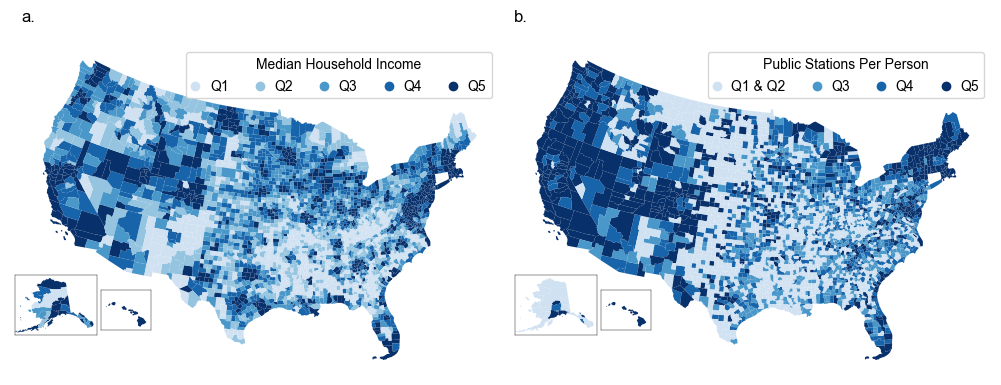

In [9]:
quintile_county_plots(income_col="income_quantile_county_US_imputed", 
                      stations_col="stations_pp_quantile",
                      savestr="USquantiles",
                      fignumber='1ab')

# Figure S1

/var/folders/x0/47mhggk13ms4ct1vkkn6b88r0000gs/T/ipykernel_34777/1587950095.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


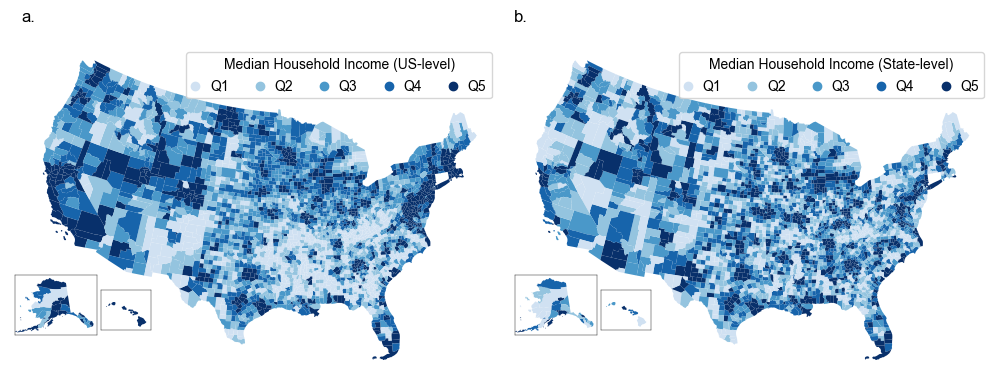

In [10]:
quintile_county_plots(income_col="income_quantile_county_US_imputed", 
                      stations_col="income_quantile_county_state_imputed",
                      savestr="Statequantiles_IncomeOnly", 
                      title1='Median Household Income (US-level)',
                      title2='Median Household Income (State-level)',
                      fignumber='S1')